In [4]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter as gf
from scipy.signal import find_peaks
import tiff_file

In [2]:
%matplotlib notebook

In [3]:
#
#

#Set dimensions
nx = 128
ny = 128

drop_center = np.array([15,5])
drop_radius = 28

xx = np.arange(-(nx-1)/2. + drop_center[0], nx/2. + drop_center[0])
yy = np.arange(-(ny-1)/2. + drop_center[1], ny/2. + drop_center[1])
x,y = np.meshgrid(yy,xx)
q = drop_radius**2 - (x**2 + y**2)
angles = np.arctan2(x,y)

drop = q * (q>0)

<IPython.core.display.Javascript object>


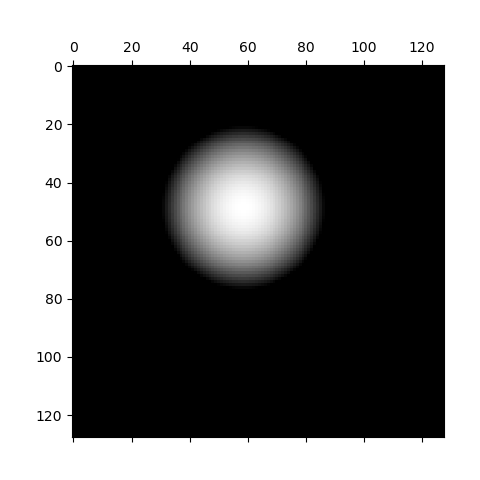

In [5]:
plt.matshow(drop, cmap = cm.gray)

In [6]:
deriv_x = drop[1:,:]-drop[:-1,:]
deriv_y = drop[:,1:]-drop[:,:-1]

deriv = deriv_x[:,1:] - deriv_y[1:,:]

<IPython.core.display.Javascript object>


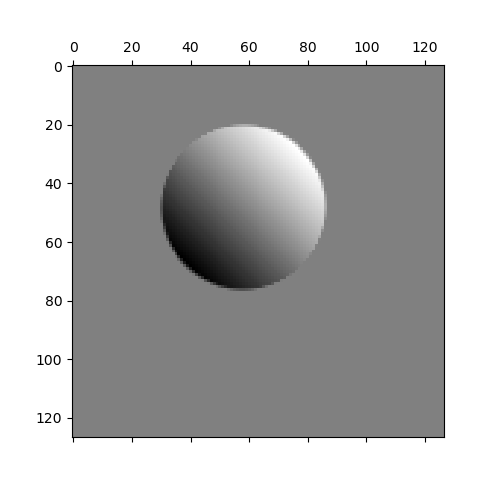

In [8]:
plt.matshow(deriv, cmap=cm.gray)

In [38]:
deriv.min()

-76.0

In [235]:
def droplet_dic_image(nx,ny,drop_radius,drop_center=np.array([0,0]), no_dic=False):

    xx = np.arange(-(nx-1)/2. + drop_center[0], nx/2. + drop_center[0])
    yy = np.arange(-(ny-1)/2. + drop_center[1], ny/2. + drop_center[1])
    x,y = np.meshgrid(yy,xx)
    q = drop_radius**2 - (x**2 + y**2)
    angles = np.arctan2(x,y)

    drop = q * (q>0)
    
    deriv_x = drop[1:,:]-drop[:-1,:]
    deriv_y = drop[:,1:]-drop[:,:-1]

    deriv = deriv_x[:,1:] - deriv_y[1:,:]
    
    deriv_new = np.zeros_like(drop)
    deriv_new[1:,1:] = deriv
    
    if no_dic:
        deriv_new = drop**0.25
        
    deriv_new = deriv_new - deriv_new.min()
    deriv_new = deriv_new / deriv_new.max()
    
    return deriv_new

<IPython.core.display.Javascript object>


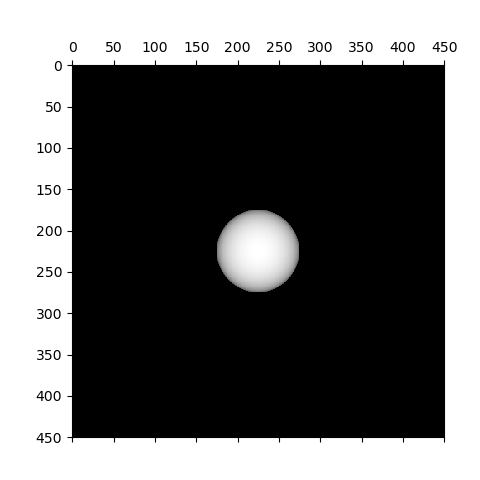

In [236]:
test_im = droplet_dic_image(450,450,50, no_dic=True)
plt.matshow(test_im, cmap=cm.gray)

<IPython.core.display.Javascript object>


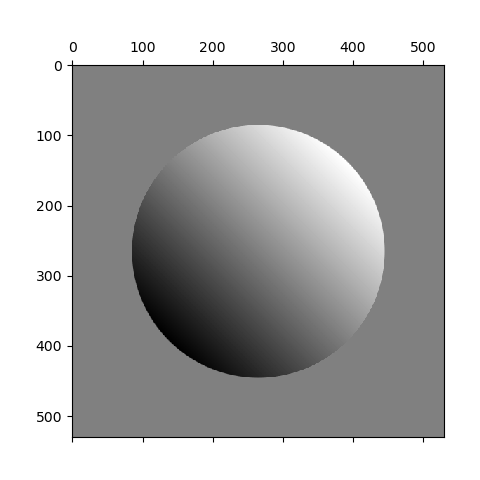

Min/max of image: 0.0, 1.0


In [79]:
test_im = droplet_dic_image(530,530,180, no_dic=False)
plt.matshow(test_im, cmap=cm.gray)
print("Min/max of image: %.1f, %.1f" % (test_im.min(), test_im.max()))

In [12]:
test_im.min()

0.0

In [190]:
data_dir = "D:\\Data\\Jack\\Data\\Capsule_Formation\\2020-02-28_XS_XLS_PFS\\"
data_file = "JB01_40X30S_60X_02.tif"

im = tiff_file.imread(data_dir+data_file)

<IPython.core.display.Javascript object>


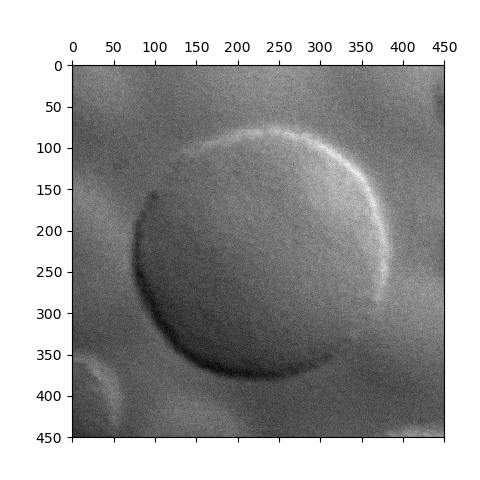

In [191]:
plt.matshow(im[0], cmap=cm.gray)

In [112]:
def droplet_dic_image_error(params, true_image, nx, ny):
    
    drop_radius = params[0]
    drop_center_x = params[1]
    drop_center_y = params[2]

    #nx,ny = true_image.shape #get dimensions of the image
    true_image = true_image.reshape(nx,ny)
    
    drop_center = np.array([drop_center_x,drop_center_y])
    
    xx = np.arange(-(nx-1)/2. + drop_center[0], nx/2. + drop_center[0])
    yy = np.arange(-(ny-1)/2. + drop_center[1], ny/2. + drop_center[1])
    x,y = np.meshgrid(yy,xx)
    q = drop_radius**2 - (x**2 + y**2)
    angles = np.arctan2(x,y)

    drop = q * (q>0)
    
    deriv_x = drop[1:,:]-drop[:-1,:]
    deriv_y = drop[:,1:]-drop[:,:-1]

    deriv = deriv_x[:,1:] - deriv_y[1:,:]
    
    deriv_new = np.zeros_like(drop)
    deriv_new[1:,1:] = deriv
    
    deriv_new = deriv_new - deriv_new.min()
    deriv_new = deriv_new / deriv_new.max()
    
    true_image = (1.0*true_image) - true_image.min()
    true_image = true_image / true_image.max()
    
    error = true_image - deriv_new
    
    return error.ravel()

In [113]:
err = droplet_dic_image_error([140, -10, 0], im[100].ravel(), 450, 450)

<IPython.core.display.Javascript object>


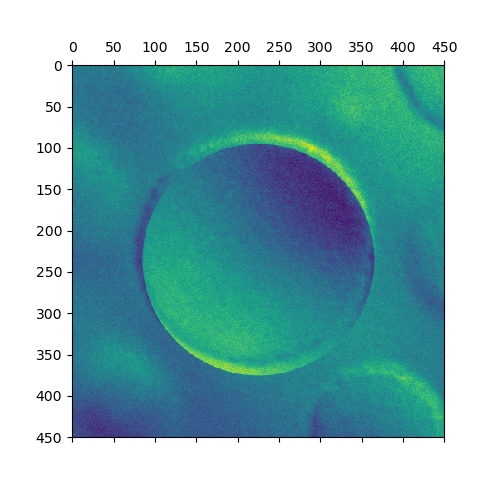

In [132]:
plt.matshow(err.reshape(450,450))


In [133]:
x0 = np.array([200,0,0]) #initial paramters: radius, x_center, y_center

res_lsq = least_squares(droplet_dic_image_error, x0, args=(gf(im[100],5).ravel(), 450, 450))

In [134]:
res_lsq

 active_mask: array([0., 0., 0.])
        cost: 3266.598891585309
         fun: array([-0.10894588, -0.10894588, -0.10894588, ...,  0.15667912,
        0.15667912,  0.15667912])
        grad: array([ 37.71413831,   6.95126917, -11.01578947])
         jac: array([[ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957],
       ...,
       [ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957]])
     message: 'Both `ftol` and `xtol` termination conditions are satisfied.'
        nfev: 32
        njev: 16
  optimality: 37.71413831152638
      status: 4
     success: True
           x: array([ 1.99575631e+02, -6.43516123e-02,  1.76815088e-01])

In [83]:
im[100].shape

(450L, 450L)

In [104]:
im_1d = im[100].ravel()

In [105]:
im_1d.shape

(202500L,)

<IPython.core.display.Javascript object>


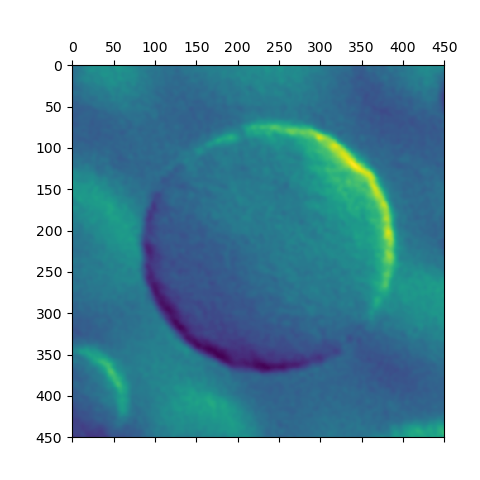

In [192]:
plt.matshow(1.0*gf(im[353],2) - gf(im[353], 100))

In [186]:
test_im = droplet_dic_image(450,450,148)

In [193]:
im_corr = fftshift(ifft2(fft2(test_im)*np.conj(fft2(im[0]*1.0))))
nx,ny = im[0].shape
xc = nx/2
yc = ny/2
im_corr_central_region = abs(im_corr[xc-(nx/4):xc+(nx/4), yc-(ny/4):yc+(ny/4)])

<IPython.core.display.Javascript object>


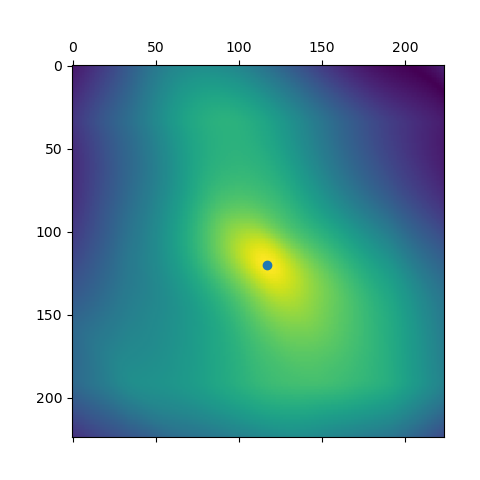

In [197]:
plt.matshow(im_corr_central_region)
arg_max =np.unravel_index(im_corr_central_region.argmax(), im_corr_central_region.shape)
plt.scatter(arg_max[1], arg_max[0])

In [230]:
def correlate_two_images(image1, image2):
    im_corr = abs(fftshift(ifft2(fft2(image1-image1.mean())*np.conj(fft2(image2-image2.mean())))))
    im_corr = im_corr / (image1.std()*image2.std())
    return im_corr

def correlation_over_radii(true_image, start_radius, stop_radius, stepsize, center, no_dic=False, peak_width=5, sub_mean=False):
    if sub_mean:
        true_image = 1.0*true_image-true_image.mean()
    true_image = (1.0*true_image)-true_image.min()
    true_image = true_image / true_image.max()
    radii = np.arange(start_radius,stop_radius+1,stepsize)
    corr_peak_values = np.zeros_like(radii,dtype=np.int64)
    corr_peak_positions = np.zeros((len(radii),2))
    nx,ny = true_image.shape
    for i,r in enumerate(radii):
        test_im = droplet_dic_image(nx,ny,r,drop_center=center,no_dic=no_dic)
        im_corr = correlate_two_images(test_im, true_image)
        xc = nx/2
        yc = ny/2
        im_corr_central_region = im_corr[xc-(nx/4):xc+(nx/4), yc-(ny/4):yc+(ny/4)]
        corr_peak_values[i] = im_corr_central_region.max()
        arg_max = np.unravel_index(im_corr_central_region.argmax(), im_corr_central_region.shape)
        corr_peak_positions[i] = arg_max
    pfit = scipy.polyfit(radii, corr_peak_values,1)
    linear_fit = scipy.polyval(pfit, radii)
    peak_a = find_peaks(corr_peak_values,width=peak_width)
    peak_radii = radii[peak_a[0]]
    peak_pos = corr_peak_positions[peak_a[0]]
    return radii, corr_peak_values, corr_peak_values-linear_fit, corr_peak_positions, peak_radii, peak_pos

<IPython.core.display.Javascript object>


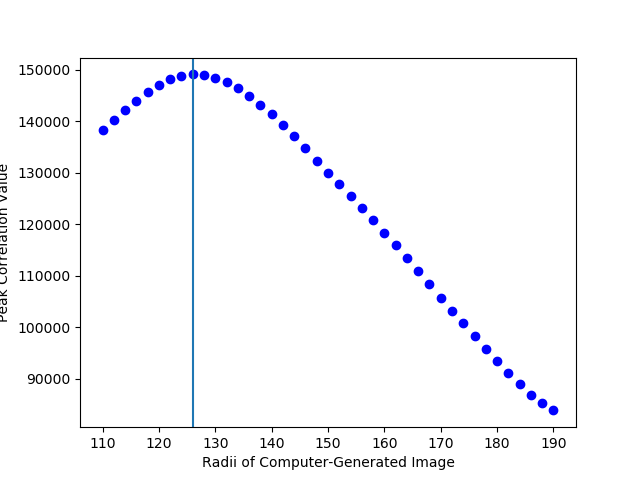

[[ 75. 104.]]


<IPython.core.display.Javascript object>


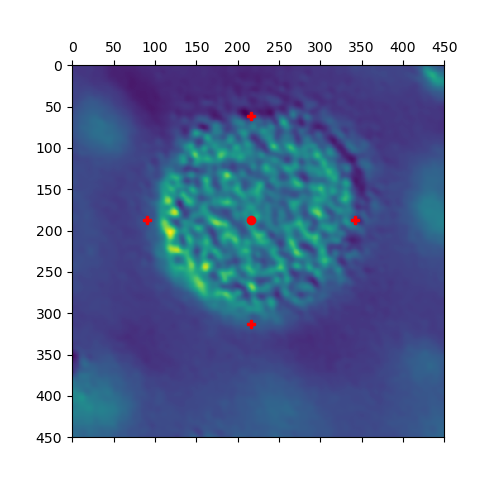

In [238]:
plt.figure()
gf_size_1 = 3
frame = 504
#r_a, cpv_a, cpv_a_lf, cpp_a, pra, pp = correlation_over_radii(gf(im[503],gf_size), 80, 180, 2, [0,0],no_dic=True)
r_b, cpv_b, cpv_b_lf, cpp_b, prb, pp = correlation_over_radii(1.0*gf(im[frame],gf_size_1) - gf(im[frame], 100), 
                                                              110, 190, 2, [0,0],
                                                              no_dic=True,sub_mean=True)
#plt.plot(r_a,cpv_a,'ro')
#if len(pra)>0:
#    plt.axvline(pra[0])
plt.plot(r_b,cpv_b,'bo')
print(pp)
plt.ylabel("Peak Correlation Value")
plt.xlabel("Radii of Computer-Generated Image")
if len(prb)>0:
    plt.axvline(prb[0])

true_image = np.flipud(np.fliplr(1.0*gf(im[frame],gf_size_1) - gf(im[frame], 100)))
im_filt = true_image - true_image.mean() # abs(1.0*true_image-true_image.mean())
plt.matshow(im_filt)
cx,cy = im[frame].shape
sx = cx/4; sy=cy/4
plt.plot(sx+pp[0][1],sy+pp[0][0],'ro')
plt.plot(sx+pp[0][1]+prb[0],sy+pp[0][0],'rP')
plt.plot(sx+pp[0][1]-prb[0],sy+pp[0][0],'rP')
plt.plot(sx+pp[0][1],sy+pp[0][0]+prb[0],'rP')
plt.plot(sx+pp[0][1],sy+pp[0][0]-prb[0],'rP')

In [69]:
im.shape

(1907L, 450L, 450L)

<IPython.core.display.Javascript object>


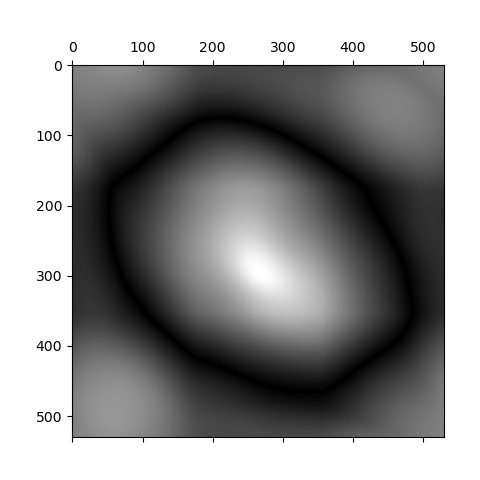

In [135]:
imcorr = correlate_two_images(gf(im[300],5),droplet_dic_image(530,530,180,drop_center=[0,0],no_dic=False))
plt.matshow(imcorr, cmap=cm.gray)

<IPython.core.display.Javascript object>


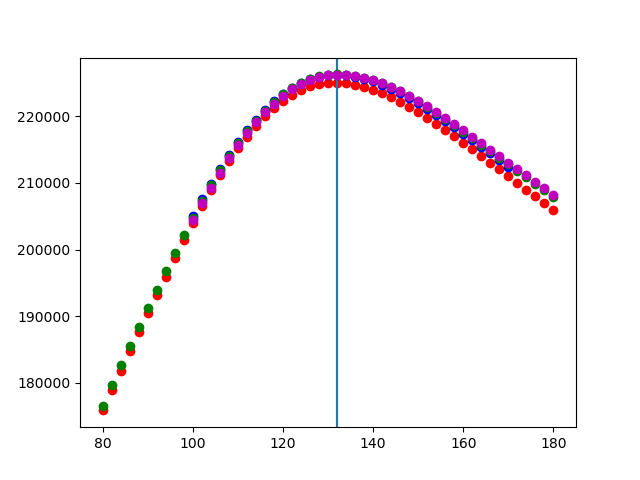

In [83]:
plt.figure()
gf_size = 4
r_a, cpv_a, cpv_a_lf, cpp_a, pra, pp = correlation_over_radii(gf(im[480],gf_size), 80, 180, 2, [0,0],no_dic=True)
r_b, cpv_b, cpv_b_lf, cpp_b, prb, pp = correlation_over_radii(gf(im[503],gf_size), 100, 170, 2, [0,0],no_dic=True)
r_c, cpv_c, cpv_c_lf, cpp_c, prc, pp = correlation_over_radii(gf(im[510],gf_size), 80, 180, 2, [0,0],no_dic=True)
r_d, cpv_d, cpv_d_lf, cpp_d, prd, pp = correlation_over_radii(gf(im[515],gf_size), 100, 180, 2, [0,0],no_dic=True)
plt.plot(r_a,cpv_a,'ro')
if len(pra)>0:
    plt.axvline(pra[0])
plt.plot(r_b,cpv_b,'bo')
if len(prb)>0:
    plt.axvline(prb[0])
plt.plot(r_c,cpv_c,'go')
plt.plot(r_d,cpv_d,'mo')

In [25]:
len(pra)

0

<IPython.core.display.Javascript object>


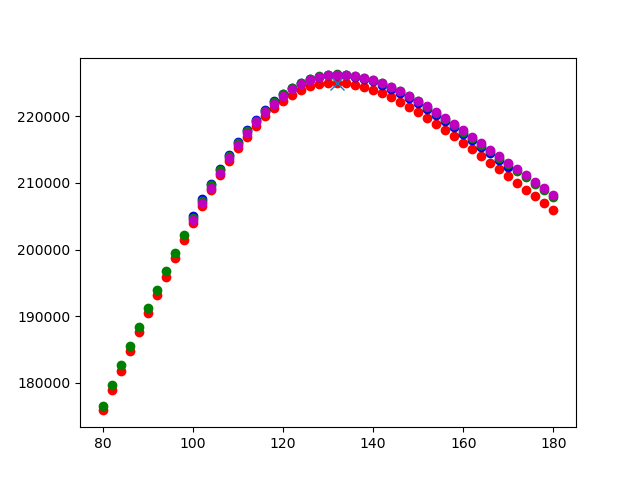

In [84]:
plt.figure()
plt.plot(r_a,cpv_a,'ro')
peak_a = find_peaks(cpv_a)
plt.plot(r_a[peak_a[0]],cpv_a[peak_a[0]],'x',ms=10)
plt.plot(r_b,cpv_b,'bo')
plt.plot(r_c,cpv_c,'go')
plt.plot(r_d,cpv_d,'mo')

In [207]:
peak_a

(array([24], dtype=int64), {})

In [207]:
r, cpv, cpv_lf, cpp, pr, pp = correlation_over_radii(gf(im[330],gf_size), 110, 190, 2, [0,0],no_dic=False,sub_mean=True)
print pr

frames = np.arange(450, 530, 2)
found_radius = np.zeros_like(frames)
found_position = np.zeros((len(frames),2))
for i,fr in enumerate(frames):
    if fr>500:
        no_dic=True
    else:
        no_dic=False
    r_a, cpv_a, cpv_a_lf, cpp_a, pr, pp = correlation_over_radii(1.0*gf(im[fr],2) - gf(im[fr], 100), 
                                                                 100, 190, 2, [0,0],no_dic=no_dic,sub_mean=False)
    print fr,pr
    if len(pr)>0:
        found_radius[i] = pr[0]
        found_position[i] = pp[0]

[]
450 [150]
452 [150]
454 [150]
456 [150]
458 [150]
460 [150]
462 [150]
464 [150]
466 [150]
468 [150]
470 [150]
472 [150]
474 [150]
476 [150]
478 [150]
480 [148]
482 [148]
484 [148]
486 [148]
488 [146]
490 [146]
492 [146]
494 [146]
496 [144]
498 [146]
500 [128 162]
502 [134]
504 [132]
506 [130]
508 [128]
510 [128]
512 [126]
514 [124]
516 [122]
518 [122]
520 [120]
522 [120]
524 [118]
526 [118]
528 [116]


<IPython.core.display.Javascript object>


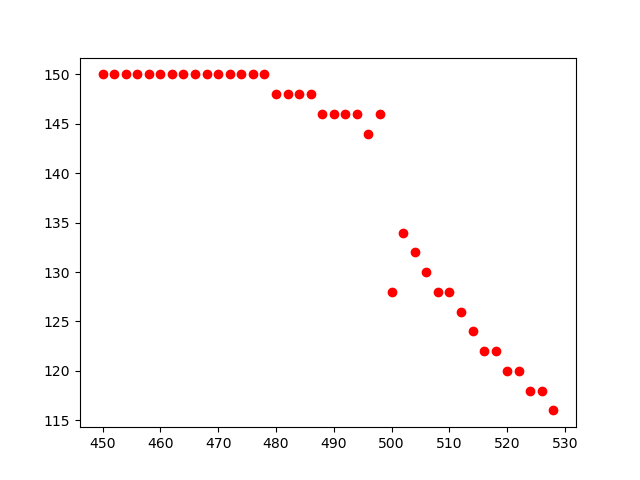

<IPython.core.display.Javascript object>


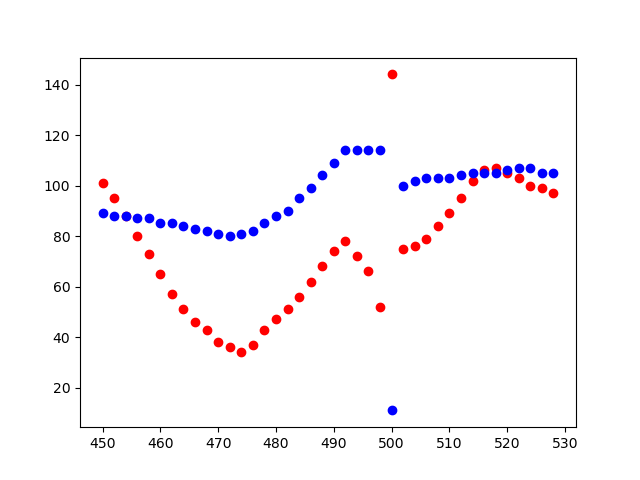

In [208]:
plt.figure()
plt.plot(frames, found_radius, 'ro')
plt.figure()
plt.plot(frames, found_position[:,0], 'ro')
plt.plot(frames, found_position[:,1], 'bo')

Frame: 502


<IPython.core.display.Javascript object>


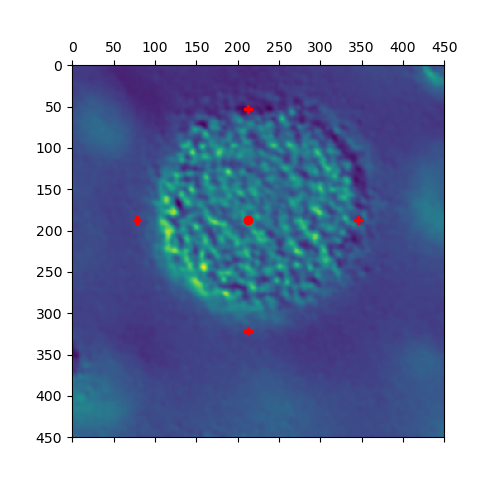

In [214]:
i = 26
print("Frame: %i" % (frames[i]))
plt.matshow(np.flipud(np.fliplr(1.0*gf(im[frames[i]],2) - gf(im[frames[i]], 100))))
cx,cy = im[0].shape
sx = cx/4; sy=cy/4
plt.plot(sx+found_position[i][1],sy+found_position[i][0],'ro')
plt.plot(sx+found_position[i][1]+found_radius[i],sy+found_position[i][0],'rP')
plt.plot(sx+found_position[i][1]-found_radius[i],sy+found_position[i][0],'rP')
plt.plot(sx+found_position[i][1],sy+found_position[i][0]+found_radius[i],'rP')
plt.plot(sx+found_position[i][1],sy+found_position[i][0]-found_radius[i],'rP')